In [57]:
import hcp_utils as hcp

import numpy as np
from brainvistools.surf.mpl import *


def surf2ax(
    vertices,
    faces,
    overlay,
    ax,
    view=90,
    cmap="viridis",
    label=False,
    vmax=None,
    vmin=None,
    x_rotate=270,
    title=None,
    mask=None,
    mask_colour=None,
    transparency=1,
    show_back=False,
    alpha_colour=None,
    flat_map=False,
    z_rotate=0,
    neighbours=None,
    parcel=None,
    parcel_cmap=None,
    filled_parcels=False,
):
    ax.set_xlim([-0.8, +0.8])
    ax.set_ylim([-0.6, +0.6])
    ax.set_aspect('equal', adjustable='box')
    ax.axis('off')
    linewidth = 0
    vertices = vertices.astype(np.float32)
    F = faces.astype(int)
    vertices = (vertices - (vertices.max(0) + vertices.min(0)) / 2) / max(
        vertices.max(0) - vertices.min(0)
    )

    # change light source if z is rotate
    light = np.array([0, 0, 1, 1]) @ yrotate(z_rotate)
    intensity = shading_intensity(vertices, F, light=light[:3], shading=0.7)
    # make figure dependent on rotations

    if title is not None:
        plt.title(title, fontsize=25)

    if label:
        colours = np.median(overlay[F], axis=1)
    else:
        colours = np.mean(overlay[F], axis=1)
    if vmax is not None:
        colours = (colours - vmin) / (vmax - vmin)
        colours = np.clip(colours, 0, 1)
    else:
        vmax = colours.max()
        vmin = colours.min()
        colours = (colours - colours.min()) / (colours.max() - colours.min())
    C = plt.get_cmap(cmap)(colours)
    if alpha_colour is not None:
        C = adjust_colours_alpha(C, np.mean(alpha_colour[F], axis=1))

    if parcel is not None:
        C = add_parcellation_colours(
            C,
            parcel,
            F,
            parcel_cmap,
            mask,
            mask_colour=mask_colour,
            filled=filled_parcels,
            neighbours=neighbours,
        )

    # adjust intensity based on light source here
    C[:, 0] *= intensity
    C[:, 1] *= intensity
    C[:, 2] *= intensity

    MVP = (
        perspective(25, 1, 1, 100)
        @ translate(0, 0, -3)
        @ yrotate(view)
        @ zrotate(z_rotate)
        @ xrotate(x_rotate)
        @ zrotate(270 * flat_map)
    )
    # translate coordinates based on viewing position
    V = np.c_[vertices, np.ones(len(vertices))] @ MVP.T

    V /= V[:, 3].reshape(-1, 1)
    center = np.array([0, 0, 0, 1]) @ MVP.T
    center /= center[3]
    V = V[F]

    # triangle coordinates
    T = V[:, :, :2]
    # get Z values for ordering triangle plotting
    Z = -V[:, :, 2].mean(axis=1)
    # sort the triangles based on their z coordinate. If front/back views then need to sort a different axis
    front, back = frontback(T)
    if show_back == False:
        T = T[front]
        s_C = C[front]
        Z = Z[front]
    else:
        s_C = C
    I = np.argsort(Z)
    T, s_C = T[I, :], s_C[I, :]

    collection = PolyCollection(
        T,
        closed=True,
        linewidth=linewidth,
        antialiased=False,
        facecolor=s_C,
        edgecolor=s_C,
        cmap=cmap,
        rasterized=True,
    )
    collection.set_alpha(transparency)

    ax.add_collection(collection)


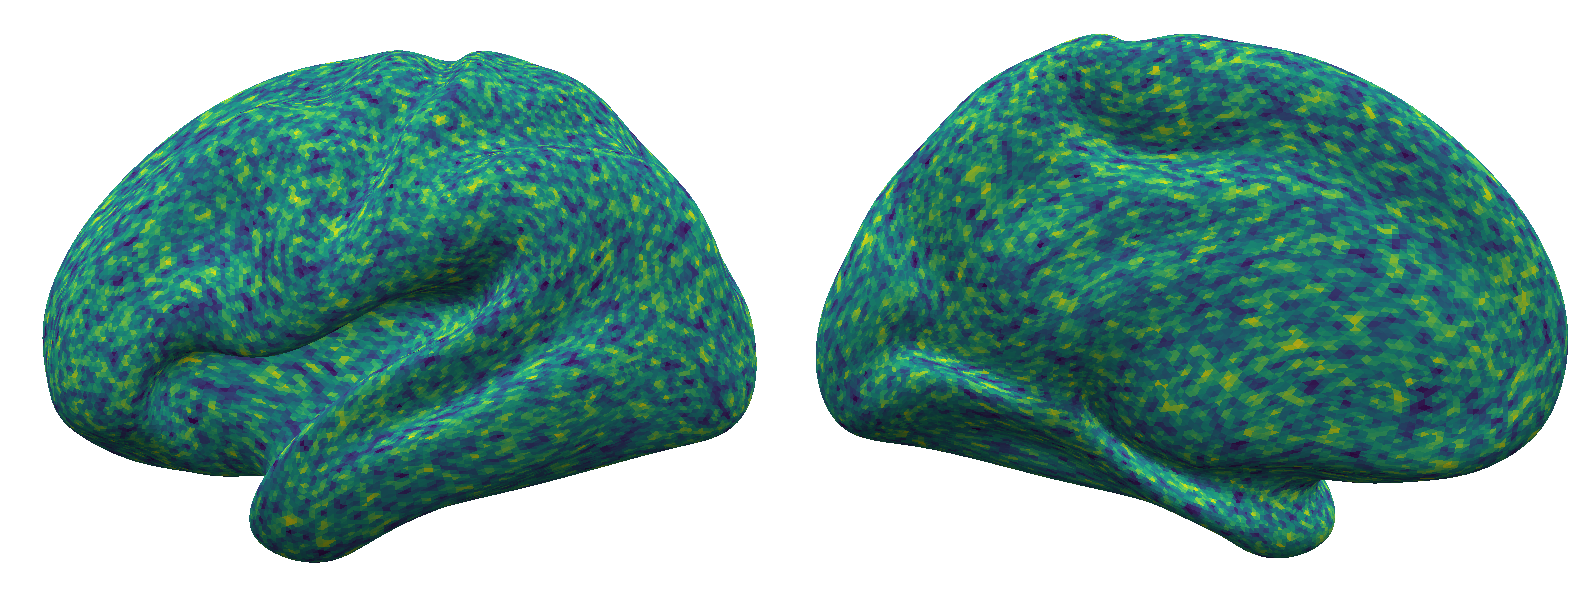

In [61]:
fig, axs = plt.subplots(ncols=2,layout='tight', figsize=(16, 8))
vertices, faces = hcp.mesh.inflated_left
surf2ax(vertices, faces, overlay=np.random.rand(len(vertices)), ax=axs[0])
surf2ax(vertices, faces, overlay=np.random.rand(len(vertices)), ax=axs[1], view=270)


In [7]:
axs[1].set_ylim((-1, 1))

(-1.0, 1.0)